
📊 Classification Report:
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       581
         joy       0.95      0.95      0.95       695
        love       0.81      0.86      0.83       159
       anger       0.93      0.92      0.92       275
        fear       0.87      0.89      0.88       224
    surprise       0.73      0.62      0.67        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000

✅ Accuracy: 0.9235
✅ Precision: 0.9231923774562253
✅ Recall: 0.9235
✅ F1-Score: 0.9231257158010066


c:\Users\manas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


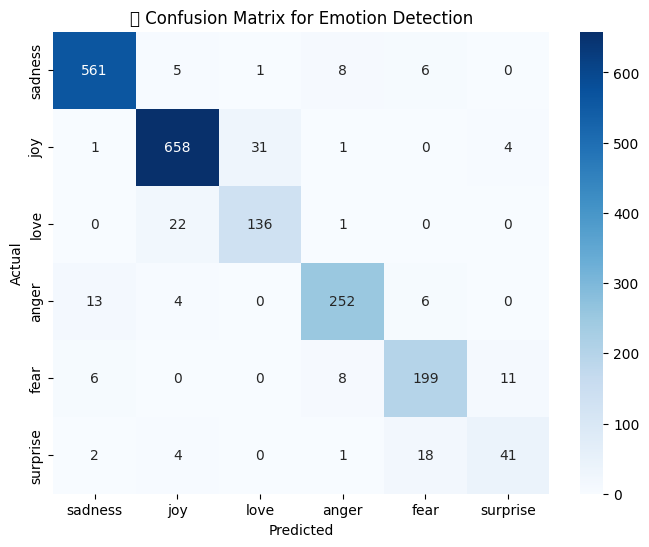

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

model_path = "../my_emotion_bot"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

dataset = load_dataset("emotion")
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
test_dataset = dataset["test"].map(tokenize)
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

from torch.utils.data import DataLoader
loader = DataLoader(test_dataset, batch_size=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

y_true, y_pred = [], []
with torch.no_grad():
    for batch in loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

label_names = dataset["train"].features["label"].names

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("✅ Precision:", precision_score(y_true, y_pred, average='weighted'))
print("✅ Recall:", recall_score(y_true, y_pred, average='weighted'))
print("✅ F1-Score:", f1_score(y_true, y_pred, average='weighted'))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📌 Confusion Matrix for Emotion Detection")
plt.show()
